# **Building a Convolutional Neural Network with Keras**

In [1]:
#Tensorflow version

import tensorflow as tf
print(tf.__version__)

2.9.1


In [2]:
#Importing libraries

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, Dropout, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
from keras.applications.efficientnet import EfficientNetB0
from keras.preprocessing import image
#from keras.preprocessing.image import load_img
from keras.models import Sequential
import numpy as np
from tensorflow.keras import regularizers

In [3]:
# 10 percent
train_dir='/home/ubuntu/From_Laptop/multi-class-NEW/12-Lead_ECG_version_2/DA_version_3/Model_Training/20 percent/Training/'
val_dir='/home/ubuntu/From_Laptop/multi-class-NEW/12-Lead_ECG_version_2/DA_version_3/Model_Training/20 percent/Validation/'


In [4]:
from tensorflow.keras import layers

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=(256,256),
                                                                 label_mode='categorical', batch_size=64, 
                                                                 )
val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
                                                                 image_size=(256,256),
                                                                 label_mode='categorical', batch_size=64,
                                                                )

Found 30805 files belonging to 5 classes.


2023-02-09 09:42:19.849319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 09:42:19.871932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 09:42:19.872253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 09:42:19.890422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 8188 files belonging to 5 classes.


In [5]:
#Normalization of the data

nrmzln_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_data = train_data.map(lambda x,
                          y: (nrmzln_layer(x), y))

val_data = val_data.map(lambda x,
                          y: (nrmzln_layer(x), y))

In [6]:
#Custom Model Architecture

from keras.layers import LeakyReLU
model = tf.keras.models.Sequential([
                                    
    # First convolution layer 
    tf.keras.layers.Conv2D(32, 3, activation=LeakyReLU(alpha=0.01),padding="same", input_shape=(256, 256, 3),use_bias=True),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.50),
    

    # Second convolution layer 
    tf.keras.layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.01),padding="same",use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    
    # Third convolution layer  
    tf.keras.layers.Conv2D(128, 2, activation=LeakyReLU(alpha=0.01),padding="same",use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.15),

    # Fourth convolution layer 
    tf.keras.layers.Conv2D(64, 1, activation=LeakyReLU(alpha=0.01),padding="same",use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.10),

    # Flatten the pooled feature maps
    tf.keras.layers.Flatten(),

    # Fully connected hidden layer
    tf.keras.layers.Dense(96, activation=LeakyReLU(alpha=0.01),use_bias=True),

    # Output layer
    tf.keras.layers.Dense(5, activation='softmax',activity_regularizer=regularizers.L2(0.001))  

])


In [7]:
#print model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       2

In [8]:
#Performance evaluation Metrics delcaration 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SensitivityAtSpecificity,SpecificityAtSensitivity,Recall,Precision

model.compile(loss=tf.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy',SensitivityAtSpecificity(0.5),SpecificityAtSensitivity(0.5),Recall(0.5),Precision(0.5)]) 


In [9]:
#Model Execution

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Initializing Device Specification
device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "GPU")
 
# Printing the DeviceSpec
print('Device Spec: ', device_spec.to_string())
 
# Enabling device logging
tf.debugging.set_log_device_placement(True)
 
# Specifying the device
with tf.device(device_spec):
    
#with tf.device('/gpu:10'):
    
    checkpoint = ModelCheckpoint("ECG_Spectrogram_Model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    mycallback=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="auto")
    
    history = model.fit(
          train_data,
          #steps_per_epoch=20, 
          epochs=150,
          verbose=1,
          validation_data = train_data,
          validation_steps=5, 
          callbacks = [mycallback,checkpoint]
    ) 

Device Spec:  /job:localhost/replica:0/device:GPU:*
Epoch 1/150


2023-02-09 09:42:40.610281: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-02-09 09:42:40.828520: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


482/482 [==============================] - ETA: 0s - loss: 2.6599 - accuracy: 0.2399 - sensitivity_at_specificity: 0.5559 - specificity_at_sensitivity: 0.5562 - recall: 0.0189 - precision: 0.2148
Epoch 1: val_accuracy improved from -inf to 0.20312, saving model to ECG_Spectrogram_Model.h5
482/482 [==============================] - 75s 150ms/step - loss: 2.6599 - accuracy: 0.2399 - sensitivity_at_specificity: 0.5559 - specificity_at_sensitivity: 0.5562 - recall: 0.0189 - precision: 0.2148 - val_loss: 1.9250 - val_accuracy: 0.2031 - val_sensitivity_at_specificity: 0.4250 - val_specificity_at_sensitivity: 0.4867 - val_recall: 0.0063 - val_precision: 0.5000
Epoch 2/150
482/482 [==============================] - ETA: 0s - loss: 1.2269 - accuracy: 0.5046 - sensitivity_at_specificity: 0.8828 - specificity_at_sensitivity: 0.8832 - recall: 0.2612 - precision: 0.6555
Epoch 2: val_accuracy did not improve from 0.20312
482/482 [==============================] - 72s 148ms/step - loss: 1.2269 - accu

In [13]:
Training_Accuracy=history.history['accuracy']
Validation_Accuracy=history.history['val_accuracy']
Validation_Specificity=history.history['val_specificity_at_sensitivity']
Validation_Sensitivity=history.history['val_sensitivity_at_specificity']
Validation_Recall=history.history['val_recall']
Validation_Precision=history.history['val_precision']
Validation_Loss=history.history['val_loss']

print("Training Accuracy: ",max(Training_Accuracy))
print("Validation Accuracy: ",max(Validation_Accuracy))
print("Validation Specificity: ",max(Validation_Specificity))
print("Validation Sensitivity: ",max(Validation_Sensitivity))
print("Validation Recall: ",max(Validation_Recall))
print("Validation Precision: ",max(Validation_Precision))
print("Validation Loss: ",min(Validation_Loss))

Training Accuracy:  0.8970946073532104
Validation Accuracy:  0.8812500238418579
Validation Specificity:  1.0
Validation Sensitivity:  0.996874988079071
Validation Recall:  0.8812500238418579
Validation Precision:  0.892405092716217
Validation Loss:  0.29616203904151917


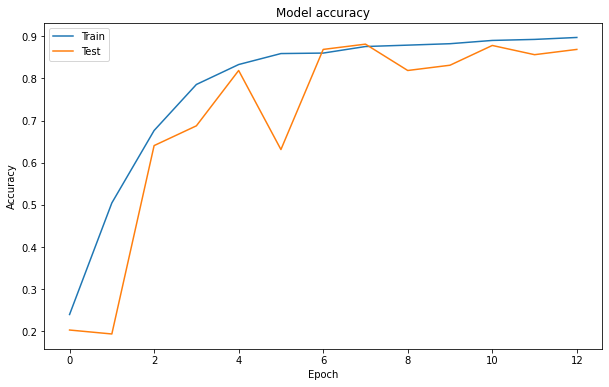

In [11]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

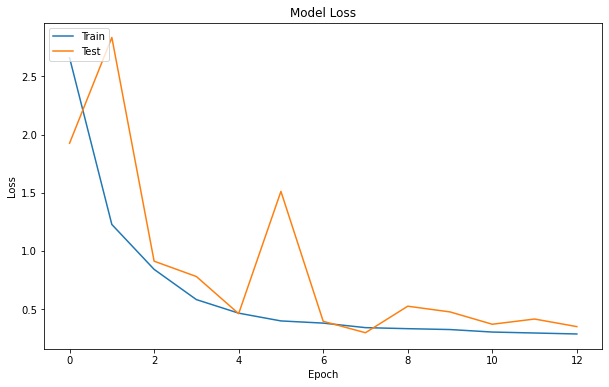

In [12]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()